# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
NUM_AGENTS = len(env_info.agents)
print('Number of agents:', NUM_AGENTS)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(NUM_AGENTS)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(NUM_AGENTS, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
# Import necessary packages

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import workspace_utils

# Actor and Critic Model

In [8]:
# Actor and Critic Model

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.bn1 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_units) # we have two agents in this environment
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""     
        x = self.bn1(state)
        x = F.leaky_relu(self.fc1(x)) # F.relu
        x = F.leaky_relu(self.fc2(x)) # F.relu
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.bn1 = nn.BatchNorm1d(state_size)    
        self.fcs1 = nn.Linear(state_size, fcs1_units) # take in the state size
        self.fc2 = nn.Linear((fcs1_units+NUM_AGENTS*action_size), fc2_units) # add actions
        self.fc3 = nn.Linear(fc2_units, 1) # 1 = a single value
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action_agent_0, action_agent_1):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = self.bn1(state)
        x = F.leaky_relu(self.fcs1(x)) # F.relu
        x = torch.cat((x, action_agent_0, action_agent_1), dim=1)
        x = F.leaky_relu(self.fc2(x)) # F.relu
        return self.fc3(x)


# Multi Agent Deep Determinitic Policy Gradient Agent with Replay Buffer and Noise

In [9]:
# Multi Agent Deep Determinitic Policy Gradient Agent with Replay Buffer and Noise

import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
NUM_AGENTS = 2          # Multi agent approach = 2; single agent approach = 1
LEARNING_LOOPS = 2      # Perform a second learning step in the step function

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent(object):
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        print("Actor net - local: ", self.actor_local)
        print("Actor net - target: ", self.actor_target)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)
        print("Critic net - local: ", self.critic_local)
        print("Critic net - target: ", self.critic_target)
        
        # Init the weights of the target network with the weights of the local network
        self.init_soft_update(self.actor_local, self.actor_target)
        self.init_soft_update(self.critic_local, self.critic_target)

        # Noise process
        self.noise = OUNoise(NUM_AGENTS * action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, states, actions_agent_0, actions_agent_1, rewards, next_state_agent_0, next_state_agent_1, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experiences / rewards
        for state, action, action_1, reward, next_state, next_state_1, done \
                in zip(states, actions_agent_0, actions_agent_1, rewards, next_state_agent_0, next_state_agent_0, dones):
            self.memory.add(state, action, action_1, reward, next_state, next_state_1, done)

        # Learn, if enough samples are available in memory
        # Learn x times as specified in LEARNING_LOOPS
        if len(self.memory) > BATCH_SIZE:
            for _ in range(LEARNING_LOOPS):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True, noise_factor=1.0):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += noise_factor * self.noise.sample().reshape((-1, 2))
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state), actor_target(next_state_other_player))
        where:
            actor_target(state) -> action
            critic_target(state, action, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, a_2, r, s', s'_2, done) tuples
            gamma (float): discount factor
        """
        ##states, actions, actions_other_player, rewards, next_states, next_states_other_player, dones = experiences
        states, actions_agent_0, actions_agent_1, rewards, next_state_agent_0, next_state_agent_1, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next_agent_0 = self.actor_target(next_state_agent_0)
        actions_next_agent_1 = self.actor_target(next_state_agent_1)
        Q_targets_next = self.critic_target(next_state_agent_0, actions_next_agent_0, actions_next_agent_1)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Current expected Q-values
        Q_expected = self.critic_local(states, actions_agent_0, actions_agent_1)
        # Compute critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred, actions_agent_1).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def init_soft_update(self, local_net, target_net):
        """ Init model parameters 
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_param, local_param in zip(target_net.parameters(), local_net.parameters()):
            target_param.data.copy_(local_param.data)        
    

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.state = None
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "action_1", "reward", "next_state", "next_state_1", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, action_1, reward, next_state, next_state_1, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, action_1, reward, next_state, next_state_1, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        actions_1 = torch.from_numpy(np.vstack([e.action_1 for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        next_states_1 = torch.from_numpy(np.vstack([e.next_state_1 for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return states, actions, actions_1, rewards, next_states, next_states_1, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# Training of the agent (DDPG)

In [12]:
# Training of the agent (DDPG)

def maddpg(n_episodes=1000, max_t=10000, print_every=100):
    """Deep Deterministic Policy Gradients DDPG
    Params
    ======
        n_episodes (int) = maximum number of episodes
        max_t (int) = max number of timesteps per episode
        print_every (int) = orint results every n episodes
    """
    scores_window = deque(maxlen=print_every)
    scores = []
    scores_mean = []
    noise_decay = 1.0  # noise multiplication factor
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset env
        states = env_info.vector_observations  # get current states of agent
        score = np.zeros(NUM_AGENTS) # set score/ reward to zero if using multiple agents
        agent.reset()
        
        for t in range(max_t):
            if i_episode < 100:
                actions_agent_0 = np.random.randn(2, 2)  # use random actions for the first 100 episodes
            else:
                actions_agent_0 = agent.act(states, noise_factor=noise_decay)  # let the agent select actions
                
            actions_agent_1 = np.flip(actions_agent_0, 0) # action of second agent/player
            env_info = env.step(actions_agent_0)[brain_name] # send actions of both agents to env
            rewards = env_info.rewards # get the rewards from env
            next_state_agent_0 = env_info.vector_observations # get next states from env
            next_state_agent_1 = np.flip(next_state_agent_0, 0)  # get the resulting states for the second agent/player
            dones = env_info.local_done # check if episode is done
            
            agent.step(states, actions_agent_0, actions_agent_1, rewards, next_state_agent_0, next_state_agent_1, dones)  # perform step of agent
            
            # update statistical variables
            states = next_state_agent_0
            score += rewards
            if np.any(dones):
                break
                
        score_max = np.max(score)  # the max score of the agents
        scores_window.append(score_max)
        scores.append(score_max)
        scores_mean.append(np.mean(scores_window)) # mean score of the agent
        
        noise_decay = max(0.999 * noise_decay, 0.01)  # reduce noise during training
        
        print('\rEpisode {:d}\tmax score: {:.2f}\t average maximum score over the last 10 episodes: {:.2f}'.format(i_episode, scores_window[-1], np.mean(list(scores_window)[-10:])), end="")
    
        if i_episode > 100 and np.mean(scores_window) > 0.5:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\t Average Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
    return scores, scores_mean

print("num_agents: ", NUM_AGENTS)
print("state_size: ", state_size)
print("action_size: ", action_size)
with workspace_utils.active_session():
    agent = Agent(state_size=24, action_size=2, random_seed=0)
    scores, scores_mean = maddpg()


num_agents:  2
state_size:  24
action_size:  2
Actor net - local:  Actor(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Actor net - target:  Actor(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Critic net - local:  Critic(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fcs1): Linear(in_features=24, out_features=128, b

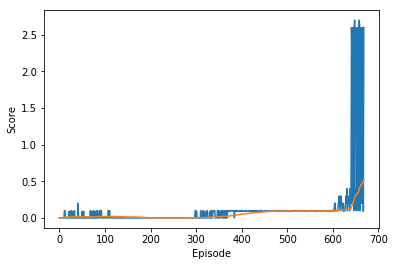

In [14]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score')
plt.plot(np.arange(len(scores_mean)), scores_mean, label='Mean')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

# Watch a Smart Agent

In [31]:
import torch.optim as optim

agent = Agent(state_size=24, action_size=2, random_seed=0)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

n_episodes=1000
NUM_AGENTS=2
score = np.zeros(NUM_AGENTS)

env_info = env.reset(train_mode=False)[brain_name] # reset env
states = env_info.vector_observations # get current states

for i_eps in range(1,n_episodes+1):
        
    actions_agent_0 = agent.act(states, noise_factor=0)  # let the agent select actions
    actions_agent_1 = np.flip(actions_agent_0, 0) # action of second agent/player
    env_info = env.step(actions_agent_0)[brain_name] # send actions of both agents to env
    rewards = env_info.rewards # get the rewards from env
    next_state_agent_0 = env_info.vector_observations # get next states from env
    next_state_agent_1 = np.flip(next_state_agent_0, 0)  # get the resulting states for the second agent/player
    dones = env_info.local_done # check if episode is done

    agent.step(states, actions_agent_0, actions_agent_1, rewards, next_state_agent_0, next_state_agent_1, dones)  # perform step of agent

    # update statistical variables
    states = next_state_agent_0
    score += rewards
    #if np.any(dones):
    #    break 

print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_eps, np.mean(score)), end="")

Actor net - local:  Actor(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Actor net - target:  Actor(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Critic net - local:  Critic(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fcs1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_